Данный ноутбук содержит минимальный пример пайплайна для обучения моделей и получения предсказаний в нужном формате для соревнования https://www.kaggle.com/c/ef-msu-master-comp1

Вы не обязаны отталкиваться от него, но, возможно, он окажется вам полезным :)


In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_log_error
from copy import deepcopy

In [3]:
def RMSLE(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """
    The Root Mean Squared Log Error (RMSLE) metric

    :param y_true: The ground truth labels given in the dataset
    :param y_pred: Our predictions

    :return: The RMSLE score
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [4]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

test_ids = test["id"]

In [5]:
train.head()

,age,sex,bmi,children,smoker,region,charges,id
0,43,male,26.030,0,no,northeast,6837.36870,1
1,58,female,28.215,0,no,northwest,12224.35085,2
2,53,male,31.350,0,no,southeast,27346.04207,3
3,54,male,29.200,1,no,southwest,10436.09600,4
4,19,male,34.900,0,yes,southwest,34828.65400,5


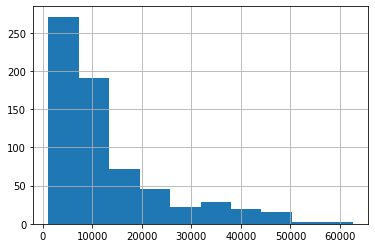

In [6]:
train["charges"].hist();

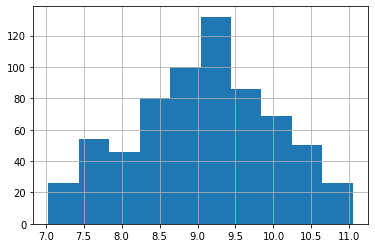

In [7]:
np.log1p(train["charges"]).hist();

In [8]:
train_y = train["charges"]  # Целевая переменная
train.drop(["charges"], axis=1, inplace=True)

In [9]:
train = pd.concat(
    [train, pd.get_dummies(train[["sex", "region", "smoker"]])], axis=1
).drop(["sex", "smoker", "region", "id"], axis=1)

test = pd.concat(
    [test, pd.get_dummies(test[["sex", "region", "smoker"]])], axis=1
).drop(["sex", "smoker", "region", "id"], axis=1)

In [10]:
def cv_and_predict(
    df_train,
    df_test,
    train_y,
    model,
    n_splits=5,
    random_state=42,
):
    """
    Функция для кросс-валидации и предикта на тест

    :param df_train: Трейн-датафрейм
    :param df_test: Тест-датафрейм
    :param train_y: Ответы на трейн
    :param model: Модель, которую мы хотим учить
    :param n_splits: Количество сплитов для KFold
    :param random_state: random_state для KFold

    :return: pred_test: Предсказания на тест; oof_df: OOF предсказания
    """

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # В датафрейме oof_df будут храниться настоящий таргет трейна и OOF предсказания на трейн.
    # Инициализируем prediction_oof нулями и будем заполнять предсказаниями в процессе валидации
    oof_df = pd.DataFrame()
    oof_df["target"] = train_y
    oof_df["prediction_oof"] = np.zeros(oof_df.shape[0])

    # Список с метриками по фолдам
    metrics = []

    # Предсказания на тест. Инициализируем нулями и будем заполнять предсказаниями в процессе валидации.
    # Наши предсказания будут усреднением n_splits моделей
    pred_test = np.zeros(df_test.shape[0])

    # Кросс-валидация
    for i, (train_index, valid_index) in enumerate(kf.split(df_train, train_y)):
        print(f"fold_{i} started")

        X_train = df_train.loc[train_index]
        y_train = train_y.loc[train_index].values

        X_valid = df_train.loc[valid_index]
        y_valid = train_y.loc[valid_index].values

        model_kf = deepcopy(model)

        model_kf.fit(X_train, y_train)

        prediction_kf = model_kf.predict(df_test)
        pred_test += prediction_kf / n_splits

        prediction = model_kf.predict(X_valid)
        oof_df.loc[valid_index, "prediction_oof"] = prediction

        cur_metric = RMSLE(y_valid, prediction)
        metrics.append(cur_metric)
        print(f"metric_{i}: {cur_metric}")

        print()
        print("_" * 100)
        print()

    print(f"metric_OOF: {RMSLE(train_y, oof_df['prediction_oof'])}")
    print(f"metric_AVG: {np.mean(metrics)}")
    print(f"metric_std: {np.std(metrics)}")
    print()
    print("*" * 100)
    print()

    return pred_test, oof_df

In [11]:
model_knn = KNeighborsRegressor(n_neighbors=50, n_jobs=4)

In [12]:
%%time

pred_test, oof_df = cv_and_predict(train, test, train_y, model_knn, n_splits=5)

fold_0 started
metric_0: 0.8998584596781326

____________________________________________________________________________________________________

fold_1 started
metric_1: 0.895700439198397

____________________________________________________________________________________________________

fold_2 started
metric_2: 0.8133744917141141

____________________________________________________________________________________________________

fold_3 started
metric_3: 0.8461224416682782

____________________________________________________________________________________________________

fold_4 started
metric_4: 0.8921192696727775

____________________________________________________________________________________________________

metric_OOF: 0.8700704119076482
metric_AVG: 0.8694350203863399
metric_std: 0.03410657488197453

****************************************************************************************************

CPU times: user 210 ms, sys: 14.8 ms, total: 224 ms
Wall time: 1.08 s

In [13]:
# Сравним OOF предсказания с константным бейзлайном и убедимся, что мы лучше

best_constant = np.expm1(np.mean(np.log1p(train_y)))
constant_baseline = np.ones(oof_df.shape[0]) * np.expm1(np.mean(np.log1p(train_y)))
RMSLE(constant_baseline, oof_df["target"])

0.9048047411379614

In [14]:
submission = pd.DataFrame()
submission["id"] = test_ids
submission["charges"] = pred_test

In [15]:
submission.head()

,id,charges
0,770,14389.255181
1,771,9664.672610
2,772,17369.504128
3,773,15279.545792
4,774,11702.576577


In [16]:
submission.to_csv("submission_baseline.csv", index=False)